# Non-Monetary Restrictions
## Goal of Notebook:
* Prepare the data for classification
* Create classification(s) models
* Compare accuracy of classification models

In [15]:
#Import Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

## Prepare the data for classification

* Remove nan data
* create train and test data
* create features and labels

In [2]:
#select only columns applicable to classifier
use_col = ['Gender', 'Race', 'Ethnicity', 'Age_at_Crime',
            'Age_at_Arrest', 'Court_Name', 'Court_ORI',
            'County_Name', 'District', 'Region',
            'Judge_Name', 'Offense_Date', 'Arrest_Date', 'Arrest_Type',
            'Top_Arrest_Law', 'Top_Charge_at_Arrest', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
            'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
            'Representation_Type', 'prior_vfo_cnt', 
            'prior_nonvfo_cnt', 'prior_misd_cnt',
            'supervision', 'NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
            'Contact_Pretrial_Service_Agency',
            'Electronic_Monitoring', 'Travel_Restrictions',
            'Passport_Surrender','No_Firearms_or_Weapons',
            'Maintain_Employment', 'Maintain_Housing',
            'Maintain_School', 'Placement_in_Mandatory_Program',
            'Removal_to_Hospital', 'Obey_Order_of_Protection',
            'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#This is for when we want to make x, y sets
pred_cols = ['NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
             'Contact_Pretrial_Service_Agency',
             'Electronic_Monitoring', 'Travel_Restrictions',
             'Passport_Surrender','No_Firearms_or_Weapons',
             'Maintain_Employment', 'Maintain_Housing',
             'Maintain_School', 'Placement_in_Mandatory_Program',
             'Removal_to_Hospital', 'Obey_Order_of_Protection',
             'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#Load Data
df = pd.read_pickle("clean_df.pkl")
df = df.filter(use_col)

#create df where no nan in NMF column
df = df[df['NMR_at_Arraign'].notna()]
#df.info()

In [3]:
#TO DO: For the Court ORI/Name Should we use a function to transform name to ORI and just use ORI
#TO DO: Top_Charge_at_Arrest contains description, may need cleaning

categories_list = ['Gender', 'Race', 'Ethnicity',
                   'Court_Name', 'County_Name', 'District',
                   'Region', 'Judge_Name', 'Top_Arrest_Law', 'Top_Charge_at_Arrest',
                   'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                   'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
                   'Representation_Type' ]
#In the categorical data change the nan values to 'Unknown'
df[categories_list] = df[categories_list].fillna('Unknown')

#Replace Age_at_Crime, Age_at_Arrest, Offense_Date, Arrest_Date with median
crime_age_median = df['Age_at_Crime'].median()
arrest_age_median = df['Age_at_Arrest'].median()
offense_date_median = df['Offense_Date'].median()
arrest_date_median = df['Arrest_Date'].median()
df['Age_at_Crime'].fillna(crime_age_median, inplace = True)
df['Age_at_Arrest'].fillna(arrest_age_median, inplace = True)
df['Offense_Date'].fillna(offense_date_median, inplace = True)
df['Arrest_Date'].fillna(offense_date_median, inplace = True)

#Replace nan with a random value with correct weighted probability
vfo_choices = [0.0, 1.0, 2.0]
df['prior_vfo_cnt'] = df['prior_vfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(vfo_choices, p=[0.84, 0.13, 0.03])))
nonvfo_choices = [0.0, 1.0, 2.0, 3.0, 4.0]
df['prior_nonvfo_cnt'] = df['prior_nonvfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(nonvfo_choices, 1, p=[0.74, 0.14, 0.06, 0.03, 0.03])))
misd_choices = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1.0]
df['prior_misd_cnt'] = df['prior_misd_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(misd_choices, 1, p=[0.54, 0.13, 0.08, 0.07, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01])))
supervision_choices = [0.0, 1.0]
df['supervision'] = df['supervision'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(supervision_choices, 1, p=[0.91, 0.09])))

#For NMR_at_Arraign and below change N to 0.0 and Y to 1.0
binary_list = ['Top_Charge_at_Arrest_Violent_Felony_Ind','NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign', 'Contact_Pretrial_Service_Agency',
               'Electronic_Monitoring', 'Travel_Restrictions', 'Passport_Surrender', 'No_Firearms_or_Weapons',
               'Maintain_Employment', 'Maintain_Housing', 'Maintain_School', 'Placement_in_Mandatory_Program',
               'Removal_to_Hospital', 'Obey_Order_of_Protection', 'Obey_Court_Conditions-Family_Offense', 'Other_NMR']

for i in binary_list:
  df[i] = df[i].map({'Y': 1.0 ,'N': 0.0})



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284096 entries, 0 to 284097
Data columns (total 40 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Gender                                   284096 non-null  object        
 1   Race                                     284096 non-null  object        
 2   Ethnicity                                284096 non-null  object        
 3   Age_at_Crime                             284096 non-null  float64       
 4   Age_at_Arrest                            284096 non-null  float64       
 5   Court_Name                               284096 non-null  object        
 6   Court_ORI                                284096 non-null  object        
 7   County_Name                              284096 non-null  object        
 8   District                                 284096 non-null  object        
 9   Region                    

In [5]:
#Separate to features and labels
features = df.drop(pred_cols, axis = 1)
labels = df['NMR_at_Arraign'].copy()

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284096 entries, 0 to 284097
Data columns (total 25 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Gender                                   284096 non-null  object        
 1   Race                                     284096 non-null  object        
 2   Ethnicity                                284096 non-null  object        
 3   Age_at_Crime                             284096 non-null  float64       
 4   Age_at_Arrest                            284096 non-null  float64       
 5   Court_Name                               284096 non-null  object        
 6   Court_ORI                                284096 non-null  object        
 7   County_Name                              284096 non-null  object        
 8   District                                 284096 non-null  object        
 9   Region                    

In [7]:
df.nunique()

Gender                                        3
Race                                          6
Ethnicity                                     3
Age_at_Crime                                 80
Age_at_Arrest                                76
Court_Name                                   71
Court_ORI                                    71
County_Name                                  42
District                                     14
Region                                        2
Judge_Name                                  674
Offense_Date                                285
Arrest_Date                                 264
Arrest_Type                                   2
Top_Arrest_Law                               60
Top_Charge_at_Arrest                       1626
Top_Charge_Severity_at_Arrest                 5
Top_Charge_Weight_at_Arrest                  11
Top_Charge_at_Arrest_Violent_Felony_Ind       2
Arraign Charge Category                      20
Representation_Type                     

In [8]:
#Transform Categorical data Numerical 

#TO DO: Determine the best endcoder, maybe use one less feature for all?

#For columns with 20 categories or less, OneHotEncode
#ohe_categories = ['Gender', 'Race', 'Ethnicity', 'District', 'Region', 
                  #'Arrest_Type', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                  #'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
                  #'Representation_Type']

#ohe = OneHotEncoder()
#for x in ohe_categories:
  #transformed = ohe.fit_transform(features[[x]])
  #features[x] = transformed.toarray().tolist()


In [9]:
#For columns with too many categories apply leave one out encoder
enc = LeaveOneOutEncoder(cols=['Court_Name', 'Court_ORI', 'County_Name', 'Judge_Name', 'Top_Arrest_Law', 'Top_Charge_at_Arrest',
                               'Gender', 'Race', 'Ethnicity', 'District', 'Region', 
                               'Arrest_Type', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                               'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category','Representation_Type'])
features =  enc.fit_transform(features, labels)
features.head()

#TO DO: ask if they did any sort of feature normalization.

,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,Court_Name,Court_ORI,County_Name,District,Region,Judge_Name,Offense_Date,Arrest_Date,Arrest_Type,Top_Arrest_Law,Top_Charge_at_Arrest,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision
0,0.071846,0.102349,0.036243,32.0,33.0,0.102367,0.102367,0.102367,0.102367,0.102367,0.118986,2020-08-01,2020-08-01,0.129376,0.063118,0.063118,0.063588,0.063588,0.086806,0.182946,0.110520,0.0,0.0,0.0,0.0
1,0.100304,0.114839,0.112635,38.0,38.0,0.137105,0.137105,0.137105,0.137105,0.102367,0.150401,2019-11-01,2019-11-01,0.024331,0.114921,0.064980,0.064299,0.085430,0.086806,0.092841,0.089417,0.0,0.0,0.0,0.0
2,0.100304,0.043031,0.036243,31.0,31.0,0.128853,0.128853,0.128853,0.075322,0.086873,0.045780,2017-04-01,2017-04-01,0.024331,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.116500,0.0,0.0,9.0,0.0
3,0.028222,0.043031,0.036243,28.0,28.0,0.016603,0.016603,0.021753,0.075322,0.086873,0.014894,2017-04-01,2017-04-01,0.129376,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.089417,1.0,0.0,1.0,0.0
4,0.100300,0.102339,0.112629,36.0,36.0,0.137074,0.137074,0.137074,0.137074,0.102360,0.140017,2020-01-01,2020-01-01,0.129371,0.114917,0.088455,0.064294,0.085423,0.086802,0.110176,0.110508,0.0,1.0,10.0,0.0


In [10]:
features = features.drop( ['Arrest_Date', 'Offense_Date'], axis =1)
features.head()

,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,Court_Name,Court_ORI,County_Name,District,Region,Judge_Name,Arrest_Type,Top_Arrest_Law,Top_Charge_at_Arrest,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision
0,0.071846,0.102349,0.036243,32.0,33.0,0.102367,0.102367,0.102367,0.102367,0.102367,0.118986,0.129376,0.063118,0.063118,0.063588,0.063588,0.086806,0.182946,0.110520,0.0,0.0,0.0,0.0
1,0.100304,0.114839,0.112635,38.0,38.0,0.137105,0.137105,0.137105,0.137105,0.102367,0.150401,0.024331,0.114921,0.064980,0.064299,0.085430,0.086806,0.092841,0.089417,0.0,0.0,0.0,0.0
2,0.100304,0.043031,0.036243,31.0,31.0,0.128853,0.128853,0.128853,0.075322,0.086873,0.045780,0.024331,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.116500,0.0,0.0,9.0,0.0
3,0.028222,0.043031,0.036243,28.0,28.0,0.016603,0.016603,0.021753,0.075322,0.086873,0.014894,0.129376,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.089417,1.0,0.0,1.0,0.0
4,0.100300,0.102339,0.112629,36.0,36.0,0.137074,0.137074,0.137074,0.137074,0.102360,0.140017,0.129371,0.114917,0.088455,0.064294,0.085423,0.086802,0.110176,0.110508,0.0,1.0,10.0,0.0


### NMR Prediction

In this section of the notebook, we will explore multiple different binary prediction models to predict whether a person will have a NMR condition
Here are the different classifications:
* TO DO: Add a heat map to show correlation
* Logistic Regression
* Naive Bayes
* KNN
* SVM
* TO DO: Try Berta and Neural Networks (Tensor Flow)

#### Logistic Regression

In [11]:
#Make a train and test set

#TO DO: check uniformity on test size and random state

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=3)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Logistic Regression Accuracy: 0.9043752713278345
[[76724   448]
 [ 7702   355]]
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     84426
         1.0       0.04      0.44      0.08       803

    accuracy                           0.90     85229
   macro avg       0.52      0.68      0.51     85229
weighted avg       0.99      0.90      0.94     85229



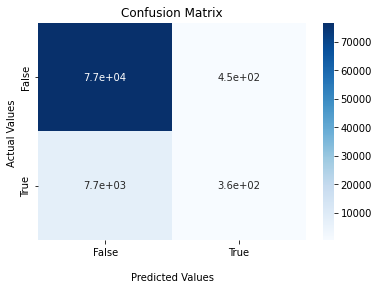

In [17]:
predictions = logisticRegr.predict(X_test)
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print("Logistic Regression Accuracy:", score)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
print(classification_report(predictions, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### Naives Bayes

In [18]:
#Create the NB classifier
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB()

Navies Bayes Accuracy: 0.750284527566908
[[58875 18297]
 [ 2986  5071]]
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.85     61861
         1.0       0.63      0.22      0.32     23368

    accuracy                           0.75     85229
   macro avg       0.70      0.58      0.58     85229
weighted avg       0.73      0.75      0.70     85229



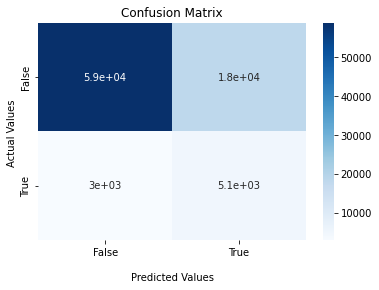

In [20]:
nb_predictions = NBclassifier.predict(X_test)
score = NBclassifier.score(X_test, y_test)
print("Navies Bayes Accuracy:", score)
cm = metrics.confusion_matrix(y_test, nb_predictions)
print(cm)
print(classification_report(nb_predictions, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### k-nearest neighbor

In [21]:
#KNN
knn_classifier = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_jobs=-1)

Navies Bayes Accuracy: 0.8953994532377477
[[75494  1678]
 [ 7237   820]]
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     82731
         1.0       0.10      0.33      0.16      2498

    accuracy                           0.90     85229
   macro avg       0.54      0.62      0.55     85229
weighted avg       0.95      0.90      0.92     85229



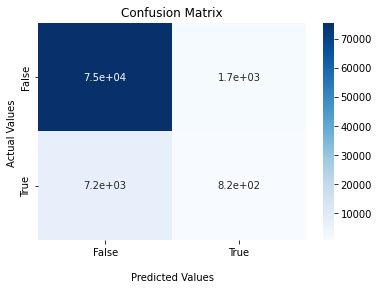

In [23]:
knn_predictions = knn_classifier.predict(X_test)
score = knn_classifier.score(X_test, y_test)
print("Navies Bayes Accuracy:", score)
cm = metrics.confusion_matrix(y_test, knn_predictions)
print(cm)
print(classification_report(knn_predictions, y_test))

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#### SVM

In [1]:
#SVM  Took too much time, will explore during phase 3
#svm_classifier = LinearSVC(C=0.0001)
#svm_classifier.fit(X_train, y_train)

#svm_classifier = svm.SVC(kernel="linear")
#svm_classifier.fit(X_train, y_train)

#### Predicting the NMR outputs
In this section the goal is to predict which NMR the person may be assigned
To do so, first we will take the dataset and only use the rows with NMR.
Then we will create a single array output of all the NMR
Then we will try the following
* Multi-output classification
* Chain Classifier *try in future or if time

In [9]:
#Create dataframe of only NMR
NMR_df = df.loc[df['NMR_at_Arraign'] == 1].reset_index(drop=True)


In [7]:
#Prepare features
NMR_features = df.drop(pred_cols, axis = 1)
feature_encoder = df['NMR_at_Arraign'].copy()

enc = LeaveOneOutEncoder(cols=['Court_Name', 'Court_ORI', 'County_Name', 'Judge_Name', 'Top_Arrest_Law', 'Top_Charge_at_Arrest',
                               'Gender', 'Race', 'Ethnicity', 'District', 'Region', 
                               'Arrest_Type', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                               'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category','Representation_Type'])
NMR_features =  enc.fit_transform(NMR_features, feature_encoder)

NMR_features = NMR_features.drop( ['Arrest_Date', 'Offense_Date'], axis =1)

NMR_features.head()


,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,Court_Name,Court_ORI,County_Name,District,Region,Judge_Name,Arrest_Type,Top_Arrest_Law,Top_Charge_at_Arrest,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision
0,0.071846,0.102349,0.036243,32.0,33.0,0.102367,0.102367,0.102367,0.102367,0.102367,0.118986,0.129376,0.063118,0.063118,0.063588,0.063588,0.086806,0.182946,0.110520,0.0,0.0,0.0,0.0
1,0.100304,0.114839,0.112635,38.0,38.0,0.137105,0.137105,0.137105,0.137105,0.102367,0.150401,0.024331,0.114921,0.064980,0.064299,0.085430,0.086806,0.092841,0.089417,0.0,0.0,0.0,0.0
2,0.100304,0.043031,0.036243,31.0,31.0,0.128853,0.128853,0.128853,0.075322,0.086873,0.045780,0.024331,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.116500,0.0,3.0,2.0,0.0
3,0.028222,0.043031,0.036243,28.0,28.0,0.016603,0.016603,0.021753,0.075322,0.086873,0.014894,0.129376,0.022056,0.006172,0.064299,0.011711,0.086806,0.018759,0.089417,1.0,1.0,0.0,0.0
4,0.100300,0.102339,0.112629,36.0,36.0,0.137074,0.137074,0.137074,0.137074,0.102360,0.140017,0.129371,0.114917,0.088455,0.064294,0.085423,0.086802,0.110176,0.110508,0.0,1.0,10.0,0.0


In [8]:
NMR_features['NMR_at_Arraign'] = df['NMR_at_Arraign']

#Create dataframe of only NMR
NMR_features = NMR_features.loc[NMR_features['NMR_at_Arraign'] == 1].reset_index(drop=True)

NMR_features

,Gender,Race,Ethnicity,Age_at_Crime,Age_at_Arrest,Court_Name,Court_ORI,County_Name,District,Region,Judge_Name,Arrest_Type,Top_Arrest_Law,Top_Charge_at_Arrest,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision,NMR_at_Arraign
0,0.100300,0.102339,0.112629,36.0,36.0,0.137074,0.137074,0.137074,0.137074,0.102360,0.140017,0.129371,0.114917,0.088455,0.064294,0.085423,0.086802,0.110176,0.110508,0.0,1.0,10.0,0.0,1.0
1,0.071828,0.102339,0.112629,37.0,37.0,0.064978,0.064978,0.064818,0.064818,0.086867,0.062128,0.024320,0.114917,0.097959,0.064294,0.085423,0.086802,0.066940,0.110508,0.0,1.0,1.0,0.0,1.0
2,0.100300,0.114830,0.112629,50.0,50.0,0.102336,0.102336,0.102336,0.102336,0.102360,0.105882,0.129371,0.114917,0.166120,0.171717,0.166266,0.086802,0.110176,0.110508,1.0,3.0,10.0,0.0,1.0
3,0.100300,0.114830,0.112629,66.0,66.0,0.082362,0.082362,0.038101,0.037301,0.086867,0.070764,0.024320,0.114917,0.073826,0.064294,0.085423,0.086802,0.116850,0.116481,1.0,1.0,10.0,0.0,1.0
4,0.100300,0.114830,0.112629,39.0,39.0,0.222045,0.222045,0.216367,0.216367,0.086867,0.472362,0.129371,0.022040,0.128079,0.171717,0.166266,0.086802,0.018727,0.033787,2.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26781,0.100300,0.102339,0.112629,28.0,28.0,0.128729,0.128729,0.128729,0.075262,0.086867,0.182076,0.129371,0.114917,0.064950,0.064294,0.085423,0.086802,0.092824,0.116481,0.0,1.0,4.0,1.0,1.0
26782,0.071828,0.102339,0.100330,28.0,29.0,0.102336,0.102336,0.102336,0.102336,0.102360,0.059149,0.129371,0.114917,0.203245,0.171717,0.155774,0.151842,0.164933,0.110508,0.0,0.0,0.0,0.0,1.0
26783,0.100300,0.114830,0.112629,28.0,29.0,0.160641,0.160641,0.160641,0.131572,0.086867,0.124402,0.129371,0.114917,0.204603,0.171717,0.166266,0.086802,0.182895,0.089404,0.0,0.0,0.0,0.0,1.0
26784,0.071828,0.114830,0.112629,35.0,35.0,0.052476,0.052476,0.052476,0.052476,0.102360,0.132576,0.129371,0.114917,0.119792,0.064294,0.085423,0.086802,0.151909,0.110508,0.0,0.0,1.0,0.0,1.0


In [10]:
#Prepare_labels
NMR_labels = NMR_df[pred_cols].copy()
NMR_labels = NMR_labels.rename(columns={'Obey_Court_Conditions-Family_Offense': 'Family_Offense'})
NMR_labels = NMR_labels.drop(['NMR_at_Arraign'], axis = 1)

In [11]:
#Make each row an array
NMR_label = NMR_labels.to_numpy()
NMR_label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [12]:
#Make Train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(NMR_features, NMR_label, train_size = .70, random_state = 3)
print(len(xtest))

8036


##### NMR MultiOutput Classifier Logistic Regression

In [15]:
#Create the model
logreg = LogisticRegression()
NMR_model = MultiOutputClassifier(estimator = logreg)
print(NMR_model)

MultiOutputClassifier(estimator=LogisticRegression())


In [16]:
#Train the model
NMR_model.fit(xtrain, ytrain)
print(NMR_model.score(xtrain, ytrain))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.38624


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [20]:

predictions = NMR_model.predict(xtest)
# Use score method to get accuracy of model
score = NMR_model.score(xtest, ytest)
print("MultiOutpur Classifier Logistic Regression Accuracy:", score)


MultiOutpur Classifier Logistic Regression Accuracy: 0.39932802389248384


##### NMR MultiOutput Classifier Naive Bayes

In [21]:
#Create the model
nb = GaussianNB()
NMR_model_1 = MultiOutputClassifier(estimator = nb)
print(NMR_model_1)

MultiOutputClassifier(estimator=GaussianNB())


In [22]:
#Train the model
NMR_model_1.fit(xtrain, ytrain)
print(NMR_model_1.score(xtrain, ytrain))


0.04096


In [23]:
predictions = NMR_model_1.predict(xtest)
# Use score method to get accuracy of model
score = NMR_model_1.score(xtest, ytest)
print("MultiOutpur Classifier Naive Bayes Accuracy:", score)

MultiOutpur Classifier Naive Bayes Accuracy: 0.04069188651070184
